In [1]:
from moarchiving.get_archive import get_mo_archive
from moarchiving.moarchiving_utils import my_lexsort
from point_sampling import get_non_dominated_points

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import time
import numpy as np
import os
import copy

In [2]:
def plot_performance(f_name=None, plot_function="add", poly_degree=2, xlabel="Archive size",
                     ylabel="Time / Archive size", title="", logx=True, logy=True, colors=None):
    if f_name is None:
        f_names = os.listdir("test_results")
        f_names = [f for f in f_names if plot_function in f]
        f_names.sort()
        f_name = f_names[-1]

    df = pd.read_csv(f"test_results/{f_name}", index_col=0)
    print(df)

    if colors is None:
        colors = list(mcolors.TABLEAU_COLORS.keys())

    fig, ax = plt.subplots()

    for i, col in enumerate(df.columns):
        # make polynomial fit ignoring the nan values
        y = df[col]
        # shorten the data to the first nan value
        if np.isnan(y).any():
            idx = np.where(np.isnan(y))[0][0]
            y = y[:idx]
        x = df.index[:len(y)]

        # p = np.polyfit(x, y, poly_degree)
        ax.plot(x, y / x, '-o', label=col, color=colors[i])
        # ax.plot(x, np.polyval(p, x), '--', color=colors[i], alpha=0.4,
        #         label=f"{p[0]:.2E} x^{poly_degree} + O(x^{poly_degree-1})")

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if logx:
        ax.set_xscale("log")
    if logy:
        ax.set_yscale("log")
    plt.legend()
    plt.grid()
    plt.title(f"{plot_function}: ({f_name[(len(plot_function)+1):-4]}) \n{title}")
    plt.show()


In [3]:
def save_results(data, index, n_dim, function):
    df = pd.DataFrame(data, index=index)
    date = time.strftime("%m%d-%H%M%S")
    df.to_csv(f"test_results/{function}_{n_dim}D_{date}.csv")

In [4]:
archive_sizes = [2 ** i for i in range(21)]
# check if directory test_results exists
if not os.path.exists("test_results"):
    os.makedirs("test_results")

In [5]:
def test_add(test_archive_sizes, n_repeats=100, n_dim=3, time_limit=100):
    ref_point = [1] * n_dim

    times = []
    archive_sizes_tested = []
    print("TEST ADD", n_dim)
    print(f"{'num points':10} | {'one by one':10} |")

    for archive_size in test_archive_sizes:
        moa = [get_mo_archive(get_non_dominated_points(archive_size, n_dim=n_dim), ref_point, n_obj=n_dim)
               for _ in range(n_repeats)]

        add_points = get_non_dominated_points(n_repeats, n_dim=n_dim)
        t0 = time.time()
        for i in range(n_repeats):
            moa[i].add(add_points[i])
        t1 = time.time()

        times.append((t1 - t0) / n_repeats)
        archive_sizes_tested.append(archive_size)

        print(f"{archive_size:10} | {t1 - t0:.8f} |")
        if t1 - t0 > time_limit:
            break
    
    save_results(data={"times": times}, index=archive_sizes_tested, n_dim=n_dim, function="add")



# Test adding points to the archive

          times
1      0.000120
2      0.000150
4      0.000319
8      0.000459
16     0.000908
32     0.001825
64     0.003607
128    0.007167
256    0.014816
512    0.029762
1024   0.059375
2048   0.121062
4096   0.238224
8192   0.485452
16384  0.974618
32768  1.962501
65536  3.923827


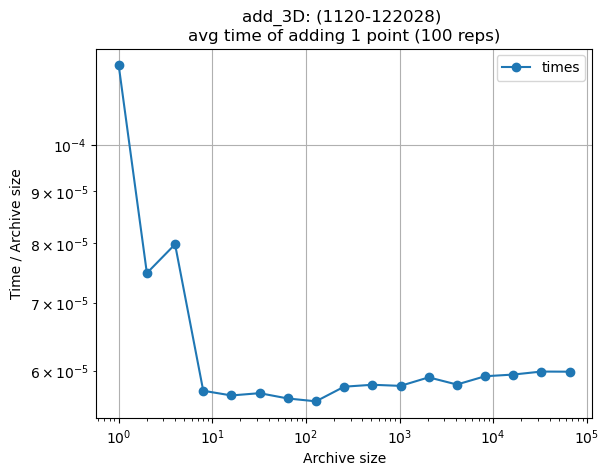

        times
1    0.000209
2    0.000369
4    0.000678
8    0.001935
16   0.006499
32   0.021304
64   0.073400
128  0.267692
256  0.913244
512  3.056560


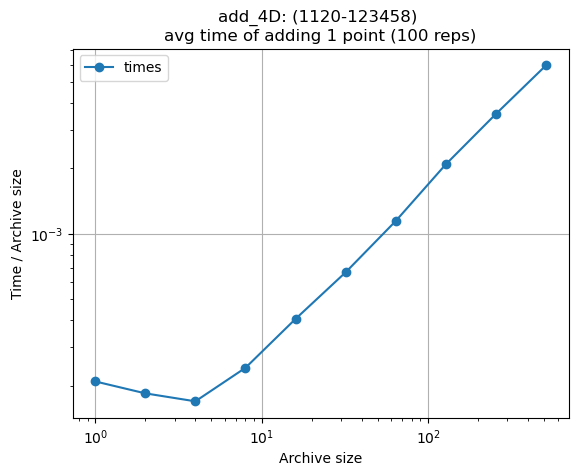

In [7]:
# test_add(test_archive_sizes=archive_sizes, n_dim=3, time_limit=200)
plot_performance(plot_function="add_3D", title="avg time of adding 1 point (100 reps)")

# test_add(test_archive_sizes=archive_sizes, n_dim=4, time_limit=200)
plot_performance(plot_function="add_4D", title="avg time of adding 1 point (100 reps)")


# Compare the time of adding different amount of points to the archive

In [13]:
def test_add_n_points(test_archive_sizes, test_n_points, n_dim=3, time_limit=10):
    ref_point = [1] * n_dim

    times_one_by_one = {
        n_points: [] for n_points in test_n_points
    }
    times_reinitialize = {
        n_points: [] for n_points in test_n_points
    }
    times_compare = {
        n_points: [] for n_points in test_n_points
    }
    archive_sizes_tested = []
    print("TEST ADD N POINTS", n_dim)
    print(f"{'num points':10} | {'one by one':10} | {'reinit':10} |")

    for archive_size in test_archive_sizes:
        for n_points in test_n_points:
            points = get_non_dominated_points(archive_size, n_dim=n_dim)

            moa_one_by_one = get_mo_archive(copy.deepcopy(points), ref_point, n_obj=n_dim)
            moa_reinitialize = get_mo_archive(copy.deepcopy(points), ref_point, n_obj=n_dim)
            moa_compare = get_mo_archive(copy.deepcopy(points), ref_point, n_obj=n_dim)

            add_points = get_non_dominated_points(n_points, n_dim=n_dim)

            t0 = time.time()
            moa_one_by_one.add_list(add_points, add_method="one_by_one")
            t1 = time.time()
            moa_reinitialize.add_list(add_points, add_method="reinit")
            t2 = time.time()
            moa_compare.add_list(add_points)
            t3 = time.time()

            times_one_by_one[n_points].append(max(t1 - t0, 10e-6))
            times_reinitialize[n_points].append(max(t2 - t1, 10e-6))
            times_compare[n_points].append(max(t3 - t2, 10e-6))

        archive_sizes_tested.append(archive_size)
        print(f"{archive_size:10} | {times_one_by_one[test_n_points[-1]][-1]:.8f} | "
              f"{times_reinitialize[test_n_points[-1]][-1]:.8f} |")
        if (times_one_by_one[test_n_points[-1]][-1] > time_limit or
                times_reinitialize[test_n_points[-1]][-1] > time_limit or
                times_compare[test_n_points[-1]][-1] > time_limit):
            print("TIME LIMIT REACHED")
            break

    data = {}
    for n_points in test_n_points:
        data[f"one_by_one_{n_points}"] = times_one_by_one[n_points]
        data[f"reinitialize_{n_points}"] = times_reinitialize[n_points]
        data[f"compare_{n_points}"] = times_compare[n_points]

    save_results(data=data, index=archive_sizes_tested, n_dim=n_dim, function="add_n_points")


TEST ADD N POINTS 3
num points | one by one | reinit     |
         1 | 0.02792501 | 0.00897574 |
         2 | 0.02590227 | 0.00800729 |
         4 | 0.02692771 | 0.00897694 |
         8 | 0.02991986 | 0.00898004 |
        16 | 0.03294158 | 0.01196718 |
        32 | 0.03789973 | 0.01396418 |
        64 | 0.04883599 | 0.01296592 |
       128 | 0.08277869 | 0.01795149 |
       256 | 0.16954589 | 0.02792549 |
       512 | 0.22440290 | 0.05086184 |
      1024 | 0.44580889 | 0.11772108 |
      2048 | 1.06016469 | 0.23537111 |
      4096 | 1.93581724 | 0.44281650 |
      8192 | 3.94547534 | 0.76596045 |
     16384 | 7.76720166 | 1.63562822 |
     32768 | 16.06226897 | 5.15819883 |
     65536 | 31.18890500 | 9.02601790 |
    131072 | 65.70438910 | 18.64300084 |
    262144 | 156.83713841 | 37.54192019 |
TIME LIMIT REACHED
        one_by_one_1  reinitialize_1  compare_1  one_by_one_10  \
1           0.000982        0.000010   0.000010       0.001008   
2           0.000010        0.000998   0.0

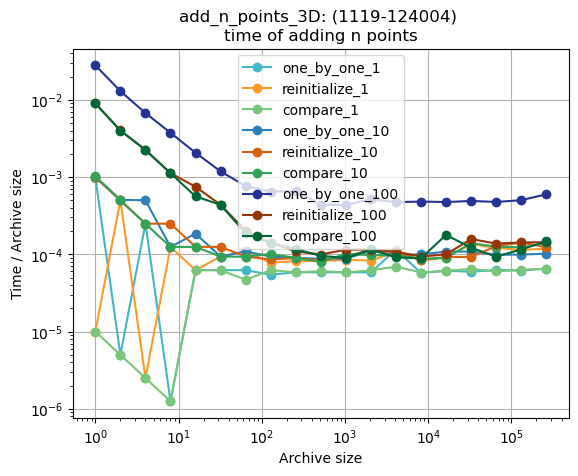

In [14]:
test_add_n_points(test_archive_sizes=archive_sizes, test_n_points=[1, 10, 100],
                  n_dim=3, time_limit=100)
plot_performance(plot_function=f"add_n_points_3D", 
                 colors=['#41b6c4', '#fe9929', '#78c679', '#2c7fb8', '#d95f0e', '#31a354', '#253494', '#993404', '#006837'],
                 title=f"time of adding n points")

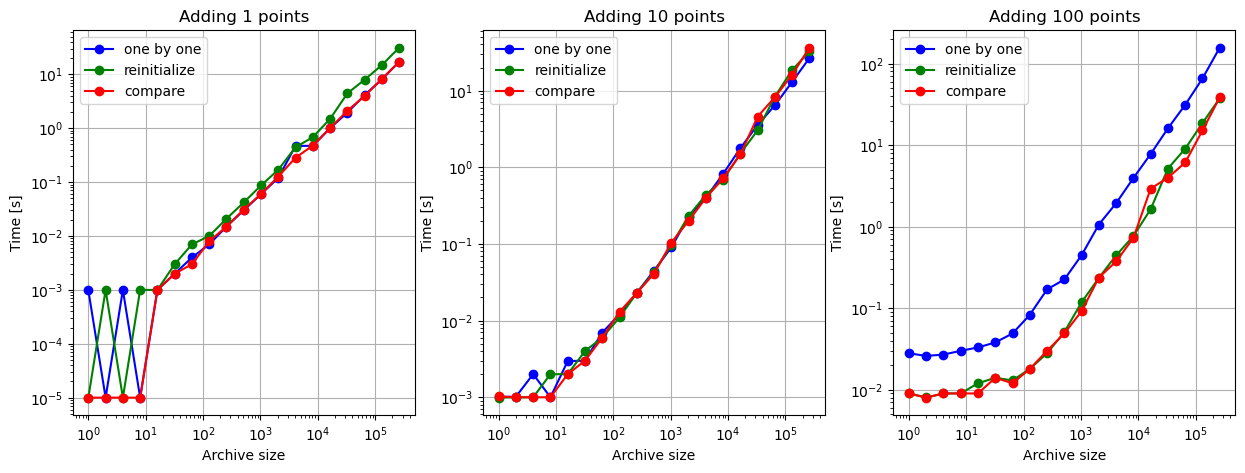

In [15]:
plot_function="add_n_points_3D"
colors=['blue', 'green', 'red']
title=f"time of adding n points"

f_names = os.listdir("test_results")
f_names = [f for f in f_names if plot_function in f]
f_names.sort()
f_name = f_names[-1]

df = pd.read_csv(f"test_results/{f_name}", index_col=0)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for ax_idx in range(3):
    ax = axs[ax_idx]

    for i, col in enumerate(df.columns[ax_idx*3:(ax_idx+1)*3]):
        y = df[col]
        # shorten the data to the first nan value
        if np.isnan(y).any():
            idx = np.where(np.isnan(y))[0][0]
            y = y[:idx]
        x = df.index[:len(y)]
        col_name = " ".join(col.split("_")[:-1])
        ax.plot(x, y, '-o', label=col_name, color=colors[i])

    ax.set_xlabel("Archive size")
    ax.set_ylabel("Time [s]")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.grid()
    ax.legend()
    ax.set_title(f"Adding {10**ax_idx} points")
plt.show()


In [16]:
def test_kink_points(test_archive_sizes, n_dim=3, time_limit=10):
    print("TEST KINK POINTS")
    times = {
        "spherical": [],
        "linear": [],
    }
    archive_sizes_tested = []
    for archive_size in test_archive_sizes:
        # read the data points and the reference point from the file
        moa = {
            "spherical": get_mo_archive(get_non_dominated_points(archive_size, mode="spherical", n_dim=n_dim), [1] * n_dim),
            "linear": get_mo_archive(get_non_dominated_points(archive_size, mode="linear", n_dim=n_dim), [1] * n_dim),
        }
        t0 = time.time()
        moa["spherical"]._get_kink_points()
        
        t1 = time.time()
        moa["linear"]._get_kink_points()
        t2 = time.time()

        times[f"spherical"].append(max(t1 - t0, 10e-6))
        times[f"linear"].append(max(t2 - t1, 10e-6))
        archive_sizes_tested.append(archive_size)
        print(f"{archive_size:10} | {t2-t1:.8f} |")

        if times[f"spherical"][-1] > time_limit or times[f"linear"][-1] > time_limit:
            break
    
    save_results(data=times, index=archive_sizes_tested, n_dim=n_dim, function="kink_points")


TEST KINK POINTS
         1 | 0.00000000 |
         2 | 0.00000000 |
         4 | 0.00099683 |
         8 | 0.00099754 |
        16 | 0.00099730 |
        32 | 0.00199437 |
        64 | 0.00501037 |
       128 | 0.01299357 |
       256 | 0.02393627 |
       512 | 0.06286097 |
      1024 | 0.09331536 |
      2048 | 0.19160604 |
      4096 | 0.41189861 |
      8192 | 1.41256523 |
     16384 | 1.88705063 |
     32768 | 3.74498296 |
     65536 | 7.39722347 |
    131072 | 14.80242300 |
    262144 | 31.55962324 |
    524288 | 64.90584207 |
   1048576 | 147.47733450 |
          spherical      linear
1          0.000010    0.000010
2          0.000010    0.000010
4          0.000010    0.000997
8          0.000997    0.000998
16         0.001995    0.000997
32         0.002992    0.001994
64         0.006980    0.005010
128        0.019924    0.012994
256        0.028922    0.023936
512        0.053828    0.062861
1024       0.105718    0.093315
2048       0.197036    0.191606
4096       0.460

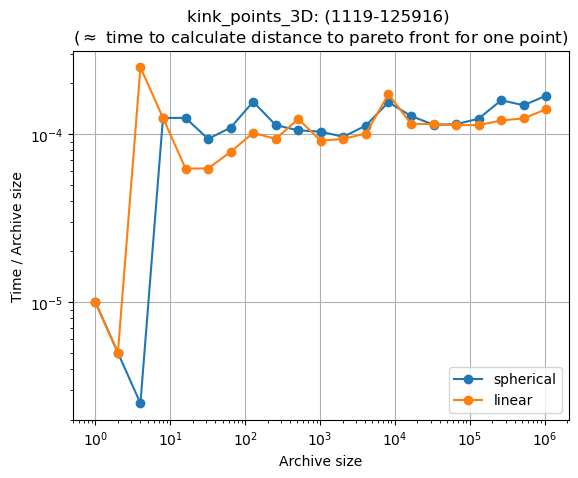

TEST KINK POINTS
         1 | 0.00099730 |
         2 | 0.00100017 |
         4 | 0.00498462 |
         8 | 0.01694322 |
        16 | 0.06582403 |
        32 | 0.28025031 |
        64 | 1.36737800 |
       128 | 6.48466396 |
       256 | 24.10153174 |
       512 | 72.00853038 |
      1024 | 225.70715785 |
       spherical      linear
1       0.000995    0.000997
2       0.001995    0.001000
4       0.004989    0.004985
8       0.018948    0.016943
16      0.072818    0.065824
32      0.297203    0.280250
64      1.305511    1.367378
128     4.616657    6.484664
256    19.208413   24.101532
512    65.958945   72.008530
1024  236.231816  225.707158


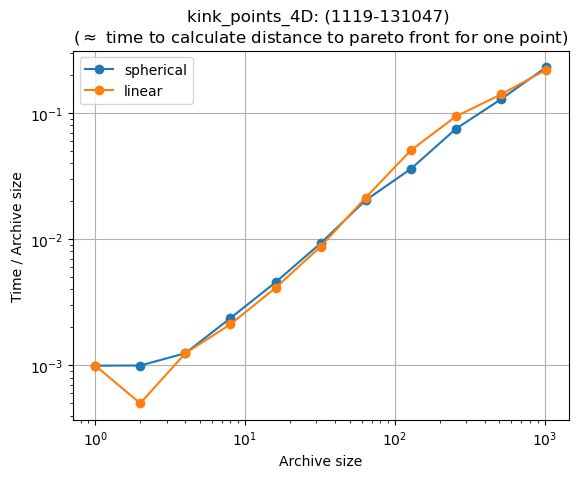

In [17]:
test_kink_points(archive_sizes, n_dim=3, time_limit=100)
plot_performance(plot_function="kink_points_3D", poly_degree=1,
                 title=r"($\approx$ time to calculate distance to pareto front for one point)")

test_kink_points(archive_sizes, n_dim=4, time_limit=100)
plot_performance(plot_function="kink_points_4D", poly_degree=2,
                 title=r"($\approx$ time to calculate distance to pareto front for one point)")


In [18]:
def test_lexsort(test_archive_sizes, n_dim=3):
    time_np = []
    time_my = []

    print("TEST LEXSORT")
    print(f"{'num points':10} | {'my lexsort':10} | {'np lexsort':10} |")
    for n in test_archive_sizes:
        pts = np.random.rand(n, n_dim)
        t0 = time.time()
        my_lexsort([pts[:, i] for i in range(n_dim)])
        t1 = time.time()
        np.lexsort([pts[:, i] for i in range(n_dim)])
        t2 = time.time()

        time_my.append(max(t1 - t0, 10e-6))
        time_np.append(max(t2 - t1, 10e-6))
        print(f"{n:10} | {t1-t0:.8f} | {t2-t1:.8f} |")
    
    save_results(data={"my_lexsort": time_my, "np_lexsort": time_np},
                 index=test_archive_sizes, n_dim=n_dim, function="lexsort")

         my_lexsort  np_lexsort
1          0.000100    0.000100
2          0.000100    0.000998
4          0.000100    0.000100
8          0.000100    0.000100
16         0.000100    0.000100
32         0.000100    0.001013
64         0.000100    0.000100
128        0.000100    0.000988
256        0.000100    0.000100
512        0.000991    0.000100
1024       0.004991    0.000100
2048       0.006976    0.000997
4096       0.008976    0.002008
8192       0.021931    0.001991
16384      0.058847    0.003985
32768      0.151617    0.006960
65536      0.278255    0.017951
131072     0.556511    0.034906
262144     1.203054    0.079786
524288     2.428503    0.172539
1048576    5.217551    0.524561


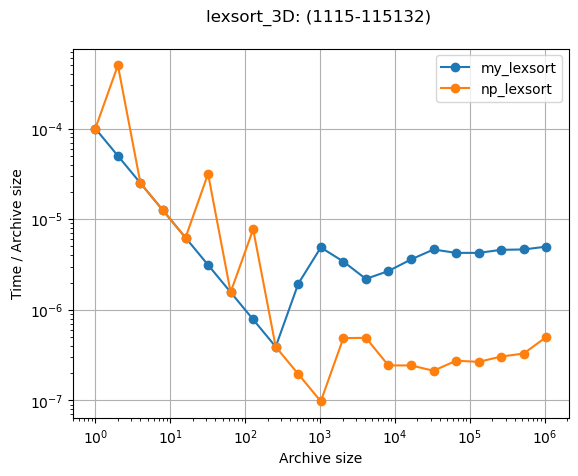

         my_lexsort  np_lexsort
1          0.001000    0.000100
2          0.000100    0.000100
4          0.000100    0.000100
8          0.000100    0.000100
16         0.000100    0.000100
32         0.000100    0.000100
64         0.000100    0.000100
128        0.000100    0.000100
256        0.000997    0.000100
512        0.000100    0.000100
1024       0.002017    0.000100
2048       0.003000    0.000100
4096       0.005982    0.000997
8192       0.010970    0.001995
16384      0.029902    0.005006
32768      0.093717    0.009973
65536      0.298233    0.024932
131072     0.703114    0.056873
262144     1.680526    0.106683
524288     2.993608    0.235404
1048576    5.413487    1.213751


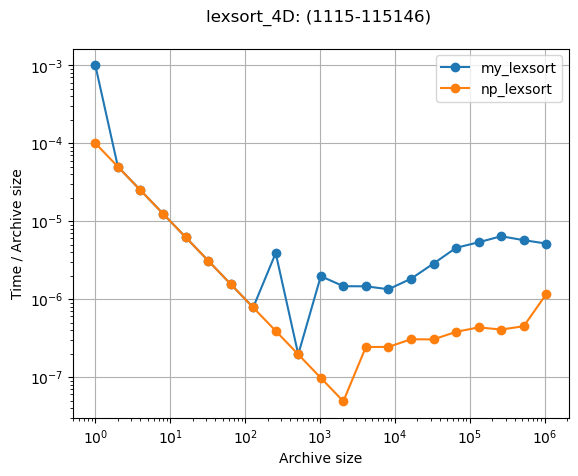

In [19]:
#test_lexsort(archive_sizes, n_dim=3)
plot_performance(plot_function="lexsort_3D")

#test_lexsort(archive_sizes, n_dim=4)
plot_performance(plot_function="lexsort_4D")

## Contributing hypervolume

In [20]:
def test_contributing_hypervolume(test_archive_sizes, n_dim=3, n_reps=10, time_limit=10):
    times = {
        "naive_spherical": [],
        "naive_linear": []
    }

    print("TEST CONTRIBUTING HYPERVOLUME")
    archive_sizes_tested = []
    for n_points_archive in test_archive_sizes:
        points = {
            "spherical": get_non_dominated_points(n_points_archive, mode="spherical", n_dim=n_dim),
            "linear": get_non_dominated_points(n_points_archive, mode="linear", n_dim=n_dim),
        }
        moa = {
            "spherical": get_mo_archive(points["spherical"], [1] * n_dim),
            "linear": get_mo_archive(points["linear"], [1] * n_dim),
        }
        
        t0 = time.time()
        _ = [moa["spherical"].contributing_hypervolume(p) for p in points["spherical"]]
        t1 = time.time()
        _ = [moa["linear"].contributing_hypervolume(p) for p in points["linear"]]
        t2 = time.time()
        
        times["naive_spherical"].append(max((t1 - t0) / n_reps, 10e-6))
        times["naive_linear"].append(max((t2 - t1) / n_reps, 10e-6))
        archive_sizes_tested.append(n_points_archive)

        print(f"{n_points_archive:10} | {times[f'naive_spherical'][-1]:.8f} | {times[f'naive_linear'][-1]:.8f} |")
        if t1 - t0 > time_limit or t2 - t1 > time_limit:
            break
    
    save_results(data=times, index=archive_sizes_tested, n_dim=n_dim, function="contributing_hypervolume")


TEST CONTRIBUTING HYPERVOLUME
         1 | 0.00001000 | 0.00001000 |
         2 | 0.00001000 | 0.00009973 |
         4 | 0.00019968 | 0.00009949 |
         8 | 0.00089777 | 0.00060098 |
        16 | 0.00369022 | 0.00319464 |
        32 | 0.01196804 | 0.01256638 |
        64 | 0.05275862 | 0.04737289 |
       128 | 0.21821597 | 0.19946716 |
       256 | 0.92791929 | 0.88254359 |
       512 | 4.18570974 | 3.75266676 |
      1024 | 18.37814004 | 16.60390520 |
      naive_spherical  naive_linear
1            0.000010      0.000010
2            0.000010      0.000100
4            0.000200      0.000099
8            0.000898      0.000601
16           0.003690      0.003195
32           0.011968      0.012566
64           0.052759      0.047373
128          0.218216      0.199467
256          0.927919      0.882544
512          4.185710      3.752667
1024        18.378140     16.603905


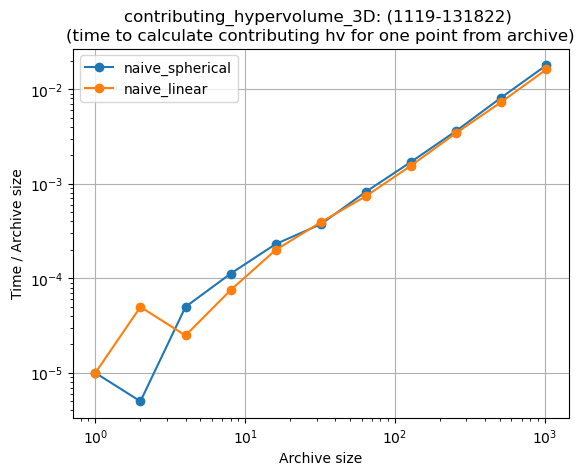

TEST CONTRIBUTING HYPERVOLUME
         1 | 0.00001000 | 0.00009980 |
         2 | 0.00009975 | 0.00009966 |
         4 | 0.00029602 | 0.00030191 |
         8 | 0.00179591 | 0.00223594 |
        16 | 0.01695466 | 0.01695817 |
        32 | 0.14161837 | 0.14770825 |
        64 | 0.88912578 | 0.93611512 |
       128 | 6.51996844 | 6.96780016 |
       256 | 50.33995621 | 49.09395013 |
     naive_spherical  naive_linear
1           0.000010      0.000100
2           0.000100      0.000100
4           0.000296      0.000302
8           0.001796      0.002236
16          0.016955      0.016958
32          0.141618      0.147708
64          0.889126      0.936115
128         6.519968      6.967800
256        50.339956     49.093950


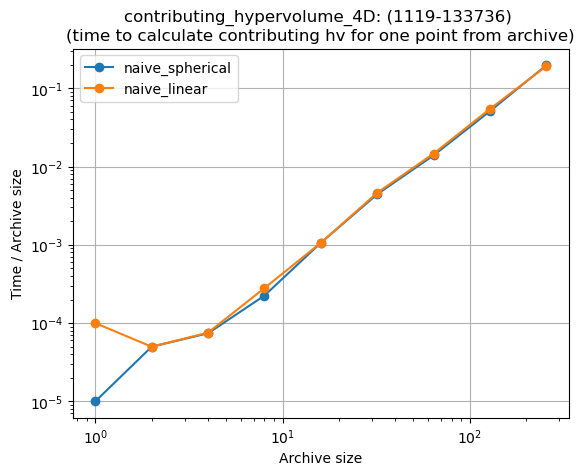

In [21]:
test_contributing_hypervolume(archive_sizes, n_dim=3, time_limit=100)
plot_performance(plot_function="contributing_hypervolume_3D",
                 title="(time to calculate contributing hv for one point from archive)")

test_contributing_hypervolume(archive_sizes, n_dim=4, time_limit=100)
plot_performance(plot_function="contributing_hypervolume_4D",
                 title="(time to calculate contributing hv for one point from archive)")

## Hypervolume improvement

In [22]:
def test_hypervolume_improvement(test_archive_sizes, time_limit=10, n_dim=3, n_reps=10):

    print("TEST HYPERVOLUME IMPROVEMENT")
    times = {
        "times_spherical": [],
        "times_linear": [],
    }
    archive_sizes_tested = []
    for n_points_archive in test_archive_sizes:
        moa = {
            "spherical": get_mo_archive(get_non_dominated_points(n_points_archive, mode="spherical", n_dim=n_dim), [1] * n_dim),
            "linear": get_mo_archive(get_non_dominated_points(n_points_archive, mode="linear", n_dim=n_dim), [1] * n_dim)
        }
        new_points = {
            "spherical": get_non_dominated_points(n_reps, mode="spherical", n_dim=n_dim),
            "linear": get_non_dominated_points(n_reps, mode="linear", n_dim=n_dim)
        }
                
        t0 = time.time()
        _ = [moa["spherical"].hypervolume_improvement(p) for p in new_points["spherical"]]
        t1 = time.time()
        _ = [moa["linear"].hypervolume_improvement(p) for p in new_points["linear"]]
        t2 = time.time()

        times["times_spherical"].append(max((t1 - t0) / n_reps, 10e-6))
        times[f"times_linear"].append(max((t2 - t1) / n_reps, 10e-6))
        archive_sizes_tested.append(n_points_archive)
                
        print(f"{n_points_archive:10} | {times['times_spherical'][-1]:.8f} | {times['times_linear'][-1]:.8f} |")

        if t1 - t0 > time_limit or t2 - t1 > time_limit:
            break
    
    save_results(data=times, index=archive_sizes_tested, n_dim=n_dim, function="hypervolume_improvement")

TEST HYPERVOLUME IMPROVEMENT
         1 | 0.00009971 | 0.00001000 |
         2 | 0.00001000 | 0.00009968 |
         4 | 0.00001000 | 0.00010061 |
         8 | 0.00009973 | 0.00009975 |
        16 | 0.00019951 | 0.00009968 |
        32 | 0.00009971 | 0.00029924 |
        64 | 0.00049860 | 0.00020220 |
       128 | 0.00029922 | 0.00029922 |
       256 | 0.00069814 | 0.00049884 |
       512 | 0.00089765 | 0.00109701 |
      1024 | 0.00179522 | 0.00139627 |
      2048 | 0.00398934 | 0.00309193 |
      4096 | 0.00678172 | 0.00608373 |
      8192 | 0.01884959 | 0.02144268 |
     16384 | 0.03161833 | 0.02981751 |
     32768 | 0.08018281 | 0.07390230 |
     65536 | 0.15568373 | 0.15179429 |
    131072 | 0.38207853 | 0.26424742 |
    262144 | 0.71837869 | 0.76615207 |
    524288 | 1.44822481 | 1.40853748 |
   1048576 | 2.17538431 | 2.99778209 |
         times_spherical  times_linear
1               0.000100      0.000010
2               0.000010      0.000100
4               0.000010      0.000

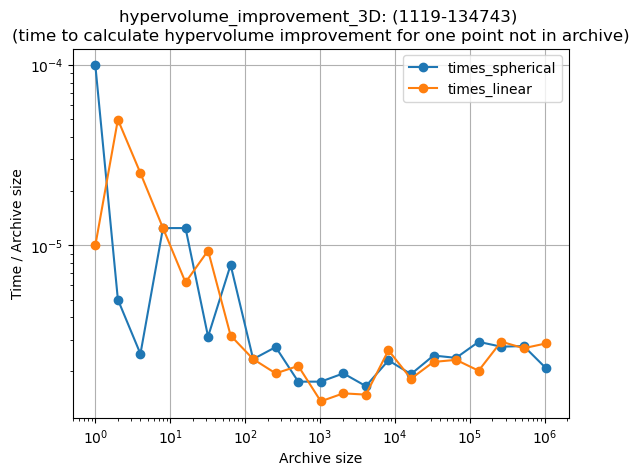

TEST HYPERVOLUME IMPROVEMENT
         1 | 0.00029900 | 0.00029922 |
         2 | 0.00049872 | 0.00049825 |
         4 | 0.00139630 | 0.00119674 |
         8 | 0.00378990 | 0.00349061 |
        16 | 0.01416180 | 0.01196520 |
        32 | 0.04637601 | 0.04487731 |
        64 | 0.14451647 | 0.14950397 |
       128 | 0.51765234 | 0.55691099 |
       256 | 1.71581643 | 1.93213761 |
       512 | 6.41276429 | 6.38313448 |
      1024 | 21.05038054 | 19.98103261 |
      times_spherical  times_linear
1            0.000299      0.000299
2            0.000499      0.000498
4            0.001396      0.001197
8            0.003790      0.003491
16           0.014162      0.011965
32           0.046376      0.044877
64           0.144516      0.149504
128          0.517652      0.556911
256          1.715816      1.932138
512          6.412764      6.383134
1024        21.050381     19.981033


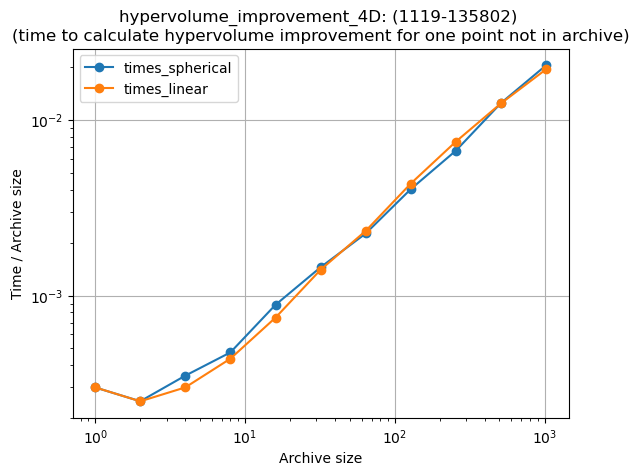

In [23]:
test_hypervolume_improvement(archive_sizes, time_limit=100, n_dim=3)
plot_performance(plot_function="hypervolume_improvement_3D",
                 title="(time to calculate hypervolume improvement for one point not in archive)")

test_hypervolume_improvement(archive_sizes, time_limit=100, n_dim=4)
plot_performance(plot_function="hypervolume_improvement_4D",
                 title="(time to calculate hypervolume improvement for one point not in archive)")